In [3]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [4]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import polars as pl
import polars.selectors as cs
from polars import col

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.plots.correlations import (
    calculate_correlations_per_trial,
    calculate_participant_stats,
    plot_correlations_per_participant,
)

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [5]:
db = DatabaseManager()
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

# Rename columns
df = df.rename(
    {
        "rating": "pain_rating",
    }
)

# Remove first 20 seconds
df = df.filter(col("normalized_timestamp") >= 20 * 1000)

# Temperature

In [6]:
referece = "temperature"
targets = [
    "brow_furrow",
    "cheek_raise",
    "mouth_open",
    "upper_lip_raise",
    "nose_wrinkle",
]

corr_by_trial = calculate_correlations_per_trial(df, referece, targets)

In [7]:
participant_means = calculate_participant_stats(corr_by_trial, targets)
participant_means.drop(cs.matches(".*_std$")).describe()

statistic,participant_id,brow_furrow_mean,cheek_raise_mean,mouth_open_mean,upper_lip_raise_mean,nose_wrinkle_mean
str,f64,f64,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",21.5,0.057989,0.076504,0.064529,0.064928,0.12837
"""std""",12.267844,0.157927,0.186154,0.163292,0.149797,0.19765
"""min""",1.0,-0.219361,-0.247318,-0.371865,-0.335079,-0.368501
"""25%""",11.0,-0.077302,-0.055461,-0.008335,-0.043026,-0.031703
"""50%""",22.0,0.068249,0.067918,0.052479,0.048888,0.144422
"""75%""",32.0,0.138207,0.17417,0.149758,0.173876,0.27304
"""max""",42.0,0.438909,0.642389,0.425344,0.363368,0.571289


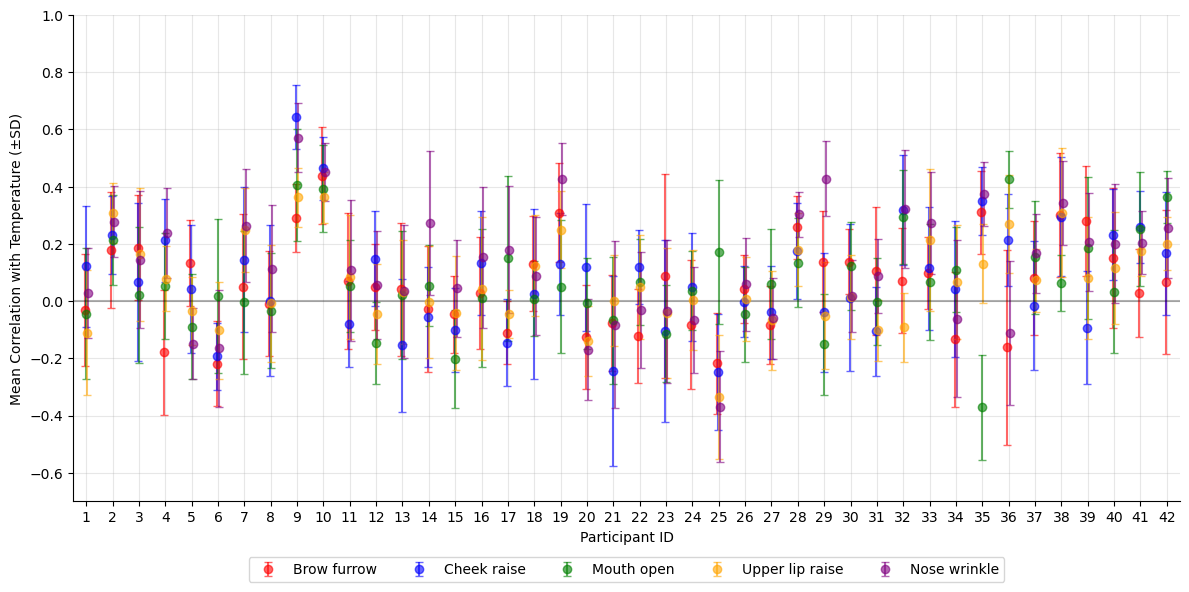

In [8]:
# Create the plot
labels_dict = {
    "brow_furrow": "Brow furrow",
    "cheek_raise": "Cheek raise",
    "mouth_open": "Mouth open",
    "upper_lip_raise": "Upper lip raise",
    "nose_wrinkle": "Nose wrinkle",
}
fig = plot_correlations_per_participant(
    participant_means, targets, labels_dict, ylim=(-0.7, 1)
)

In [34]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))


# Save the figure
path = FIGURE_DIR / "correlations_with_temperature_face.png"
fig.savefig(path)
